<a href="https://colab.research.google.com/github/zhangvi7/CSC413_FINAL_PROJECT/blob/main/FC_GANS_FINAL_PROJECT_413.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch 
import torch.nn as nn
from torchvision import datasets, transforms, utils
from torch.nn import functional as F
import matplotlib.pyplot as plt

In [ ]:
device = torch.device('cuda:' + str(0) if torch.cuda.is_available() else 'cpu')

SEED = 1

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

BATCH_SIZE = 64

In [ ]:
!wget https://www.di.ens.fr/willow/research/seeing3Dchairs/data/rendered_chairs.tar
# %mkdir -p chair_data
!tar -xvf  'rendered_chairs.tar'

86366
51819
17273
(600, 600)


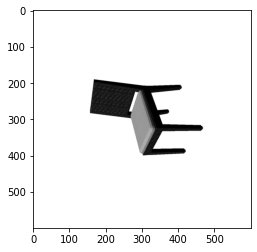

In [ ]:
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt
import torchvision as tv
import torch.utils.data as data

# ---------------- DATASET LOADER -----------------

def get_subset(indices, start, end):
    return indices[start : start + end]

# transforming from RBG to grayscale
trainTransform  = tv.transforms.Compose([tv.transforms.Grayscale(num_output_channels=1),
                                    tv.transforms.ToTensor()])

dataset = torchvision.datasets.ImageFolder("rendered_chairs", transform=trainTransform)

# ------------ SPLIT SET INTO TRAIN, VALIDATION, TEST SETS -------------

TRAIN_PCT, VALIDATION_PCT = 0.6, 0.2  # rest will go for test - TODO remove if we dont need validation set
train_count = int(len(dataset) * TRAIN_PCT)
validation_count = int(len(dataset) * VALIDATION_PCT)

print(len(dataset))
print(train_count)
print(validation_count)


indices = torch.randperm(len(dataset))

# get subset of indices for train, valid, and test sets
train_indices = get_subset(indices, 0, train_count)
validation_indices = get_subset(indices, train_count, validation_count)
test_indices = get_subset(indices, train_count + validation_count, len(dataset))

# ---------------- CREATE DATA LOADER -----------------

dataloaders = {
    "train": torch.utils.data.DataLoader(
        dataset, batch_size=BATCH_SIZE, sampler=SubsetRandomSampler(train_indices)
    ),
    "validation": torch.utils.data.DataLoader(
        dataset, batch_size=BATCH_SIZE, sampler=SubsetRandomSampler(validation_indices)
    ),
    "test": torch.utils.data.DataLoader(
        dataset, batch_size=BATCH_SIZE, sampler=SubsetRandomSampler(test_indices)
    ),
}

# ---------------- VISUALIZE IMAGE -----------------
train_loader = dataloaders["train"]

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()
# print(len(images)) # batch_size

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True  # Note: this is required for image truncation error.

# for batch_i, (real_images, _) in enumerate(train_loader):
#   print(batch_i, real_images)

img = np.squeeze(images[0]).T # Tranpose for rbg to be shape (600, 600, 3) instead of (3, 600, 600).
print(img.T.shape)

# need to remove first dimension since currently shape is (3, 600, 600), but pyplot.imshow can only plot images of dimension (N,M) (grayscale) or (N,M,3)
# img = img[0,:,:] (uncomment for grayscale)
# print(img.shape)
plt.imshow(img, cmap="gray")
plt.show()

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, input_size, hidden_dim, output_size):
    super(Discriminator, self).__init__()
    
    self.fc1 = nn.Linear(input_size, hidden_dim*4)
    self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
    self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
    self.fc4 = nn.Linear(hidden_dim, output_size)
    
    # dropout layer 
    self.dropout = nn.Dropout(0.3)

  def forward(self, x):
    # flatten image to vector
    x = x.view(-1, 600*600)
    # use leaky relu for vanishing gradient
    x = self.fc1(x)
    x = F.leaky_relu(x, 0.2) # (input, negative_slope=0.2)
    x = self.dropout(x)
    x = self.fc2(x)
    x = F.leaky_relu(x, 0.2)
    x = self.dropout(x)
    x = self.fc3(x)
    x = F.leaky_relu(x, 0.2)
    x = self.dropout(x)
    x = self.fc4(x)
    return x

In [ ]:
class Generator(nn.Module):
  def __init__(self, input_size, hidden_dim, output_size):
    super(Generator, self).__init__()
    
    self.fc1 = nn.Linear(input_size, hidden_dim)
    self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
    self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
    self.fc4 = nn.Linear(hidden_dim*4, output_size)

    # dropout layer 
    self.dropout = nn.Dropout(0.3)
  
  def forward(self, x):
    x = self.fc1(x)
    x = F.leaky_relu(x, 0.2)
    x = self.dropout(x)
    x = self.fc2(x)
    x = F.leaky_relu(x, 0.2)
    x = self.dropout(x)
    x = self.fc3(x)
    x = F.leaky_relu(x, 0.2)
    x = self.dropout(x)
    x = self.fc4(x)
    x = F.tanh(x)
    return x

In [ ]:
# hyper-params
params = {
    # Discriminator hyperparameters
    "input_size": 360000,    # 600 x 600 image
    "d_output_size": 1, 
    "d_hidden_size": 32,
    # Generator hyperparams
    "z_size": 256,       # latent vector
    "g_output_size": 360000,
    "g_hidden_size": 32,
}
# training params
config = {
    "epoch": 20,
    "lr": 1e-3,
    "batch": 64,
}

In [ ]:
# instantiate discriminator and generator
D = Discriminator(params["input_size"], params["d_hidden_size"], params["d_output_size"])
G = Generator(params["z_size"], params["g_hidden_size"], params["g_output_size"])
print(D)
print(G)

Discriminator(
  (fc1): Linear(in_features=360000, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
Generator(
  (fc1): Linear(in_features=256, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=360000, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [ ]:
# discriminator loss: d_loss = d_real_loss + d_fake_loss
def real_loss(D_out):
  labels = torch.ones(D_out.size(0)).to(device) # real labels = 1
  criterion = nn.BCEWithLogitsLoss()
  return criterion(D_out.squeeze(), labels)

def fake_loss(D_out):
  labels = torch.zeros(D_out.size(0)).to(device) # fake labels = 0
  criterion = nn.BCEWithLogitsLoss()
  return criterion(D_out.squeeze(), labels)

In [ ]:
import torch.optim as optim
d_optimizer = optim.Adam(D.parameters(), config["lr"])
g_optimizer = optim.Adam(G.parameters(), config["lr"])

In [ ]:
import pickle as pkl

# training hyperparams
num_epochs = config["epoch"]
batch_size = config["batch"]
z_size = params["z_size"]

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 400

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, params["z_size"]))
fixed_z = torch.from_numpy(fixed_z).float().to(device)

G = G.to(device)
D = D.to(device)

# train the network
D.train()
G.train()

for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        ## Important rescaling step ## 
        real_images = real_images*2 - 1  # rescale input images from [0,1) to [-1, 1)
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        
        d_optimizer.zero_grad()
        
        # 1. Train with real images

        # Compute the discriminator losses on real images 
        # smooth the real labels
        real_images = real_images.to(device)
        D_real = D(real_images)
        d_real_loss = real_loss(D_real)
        
        # 2. Train with fake images
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float().to(device)
        fake_images = G(z)
                
        # Compute the discriminator losses on fake images        
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float().to(device)
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to train mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/   20] | d_loss: 1.3984 | g_loss: 1.2093
Epoch [    1/   20] | d_loss: 0.9940 | g_loss: 0.5753
Epoch [    1/   20] | d_loss: 1.0961 | g_loss: 0.6488
Epoch [    2/   20] | d_loss: 0.9238 | g_loss: 1.0998


In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

In [ ]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

# -1 indicates final epoch's samples (the last in the list)
view_samples(-1, samples)

In [ ]:
# try subsample, crop out image whitespace, dcgans if training too slow.